# Let's make some Analytics to the data base.

I would like to know which **location** has most job offers.

In [1]:
import pandas as pd
import matplotlib as plt
from matplotlib import pyplot
import seaborn as sns
import numpy as np
import sqlite3

In [2]:
# make the connection to the DB
conn = sqlite3.connect("../data/offers.db")

# create data frame
sql = pd.read_sql_query("SELECT * FROM offers", conn)
df = pd.DataFrame(sql, columns=["id", "company", "job", "locate", "url", "date"])

df.head()

,id,company,job,locate,url,date
0,1,Dexian Inc,Entry Level Data Engineering,"Houston, TX",https://www.linkedin.com/jobs/view/entry-level...,2024-03-24
1,2,Planned Systems International,Jr Web Developer (Entry Level),United States,https://www.linkedin.com/jobs/view/jr-web-deve...,2024-03-25
2,3,Medasource,Data Analyst,New York City Metropolitan Area,https://www.linkedin.com/jobs/view/data-analys...,2024-03-25
3,4,Get It Recruit - Information Technology,Junior Software Developer - Remote | WFH,"Mount Laurel, NJ",https://www.linkedin.com/jobs/view/junior-soft...,2024-03-25
4,5,Dexian Inc,Junior Backend Engineer,"Autaugaville, AL",https://www.linkedin.com/jobs/view/junior-back...,2024-03-24


Explore the data a little:

In [3]:
df.shape

(1102, 6)

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1102 entries, 0 to 1101
Data columns (total 6 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   id       1102 non-null   int64 
 1   company  1102 non-null   object
 2   job      1102 non-null   object
 3   locate   1102 non-null   object
 4   url      1102 non-null   object
 5   date     1102 non-null   object
dtypes: int64(1), object(5)
memory usage: 51.8+ KB


In [5]:
print(df.isnull().sum())

id         0
company    0
job        0
locate     0
url        0
date       0
dtype: int64


In [6]:
df.duplicated().sum()

0

In [7]:
df.describe(include=['object'])

,company,job,locate,url,date
count,1102,1102,1102,1102,1102
unique,207,250,131,612,10
top,Patterned Learning Career,Junior Python Django Developer,United States,https://www.linkedin.com/jobs/view/entry-level...,2024-03-25
freq,175,50,246,6,279


The location data that is most repeated (top) is `United States`, but that is the default location when performing the scraping process. 

Les't see more information about `locate` columm:

In [8]:
df['locate'].head()

0                        Houston, TX
1                      United States
2    New York City Metropolitan Area
3                   Mount Laurel, NJ
4                   Autaugaville, AL
Name: locate, dtype: object

In [9]:
location = df['locate'].value_counts().to_frame()
location

,count
locate,
United States,246
"New York, NY",108
"Boston, MA",77
"Los Angeles, CA",60
"Houston, TX",53
...,...
"Winston-Salem, NC",1
"Nevada City, CA",1
"St George, UT",1


There are rows with: 
* `United States`
* just the name like `New York City Metropolitan Area`
* state - Country like `Ohio, United States`
* the city - state abbreviation like `Houston, TX` / `New York, NY`.

I would like to only have the **state abbreviation** to know in general which of them has most offers.

In [ ]:
# create a new DF without the `United States` rows
new_df = df.loc[(df['locate'] != "United States")]

# create a new column with the state abbreviation called `state_code`
new_df['state_code'] = new_df['locate'].str.split(',').str[1].str.strip()

In [11]:
new_df.head()

,id,company,job,locate,url,date,state_code
0,1,Dexian Inc,Entry Level Data Engineering,"Houston, TX",https://www.linkedin.com/jobs/view/entry-level...,2024-03-24,TX
2,3,Medasource,Data Analyst,New York City Metropolitan Area,https://www.linkedin.com/jobs/view/data-analys...,2024-03-25,NaN
3,4,Get It Recruit - Information Technology,Junior Software Developer - Remote | WFH,"Mount Laurel, NJ",https://www.linkedin.com/jobs/view/junior-soft...,2024-03-25,NJ
4,5,Dexian Inc,Junior Backend Engineer,"Autaugaville, AL",https://www.linkedin.com/jobs/view/junior-back...,2024-03-24,AL
5,6,HireMeFast LLC,Data Scientist Entry Level,"Fort Smith, AR",https://www.linkedin.com/jobs/view/data-scient...,2024-03-24,AR


Clean the data:

It seems that now, the `state_code` column has NaN value.

In [12]:
new_df.shape

(856, 7)

In [13]:
print(new_df.isnull().sum())

id             0
company        0
job            0
locate         0
url            0
date           0
state_code    15
dtype: int64


In [ ]:
# eliminate nan value
new_df.dropna(subset=["state_code"], axis=0, inplace=True)

# drop the `locate` columm because I going to use the `state_code`
new_df.drop("locate", axis=1, inplace=True)

# reset table index
new_df.reset_index(drop=True, inplace=True)

In [15]:
print(new_df.isnull().sum())

id            0
company       0
job           0
url           0
date          0
state_code    0
dtype: int64


In [16]:
new_df.shape

(841, 6)

The rows that had the form `state, United States` in `locate` columm are now in the `state_code` column as `United States`. Let's remove this value.

In [17]:
# clean the rows like `state, United States`
new_df = new_df.loc[(new_df['state_code'] != "United States")]

# reset table index
new_df.reset_index(drop=True, inplace=True)

In [18]:
new_df.shape

(802, 6)

Now let's evaluate the state with most offers:

In [19]:
new_df.describe(include=['object'])

,company,job,url,date,state_code
count,802,802,802,802,802
unique,75,140,419,10,37
top,Patterned Learning Career,Junior Python Django Developer,https://www.linkedin.com/jobs/view/entry-level...,2024-03-31,NY
freq,175,49,6,246,128


The value that is most repeated is `NY`. Let's confirm it:

In [20]:
states = new_df['state_code'].value_counts().to_frame()
states

,count
state_code,
NY,128
CA,98
TX,85
MA,82
AZ,45
MI,43
AR,39
AK,34
FL,33


And now represent this data on a graph:

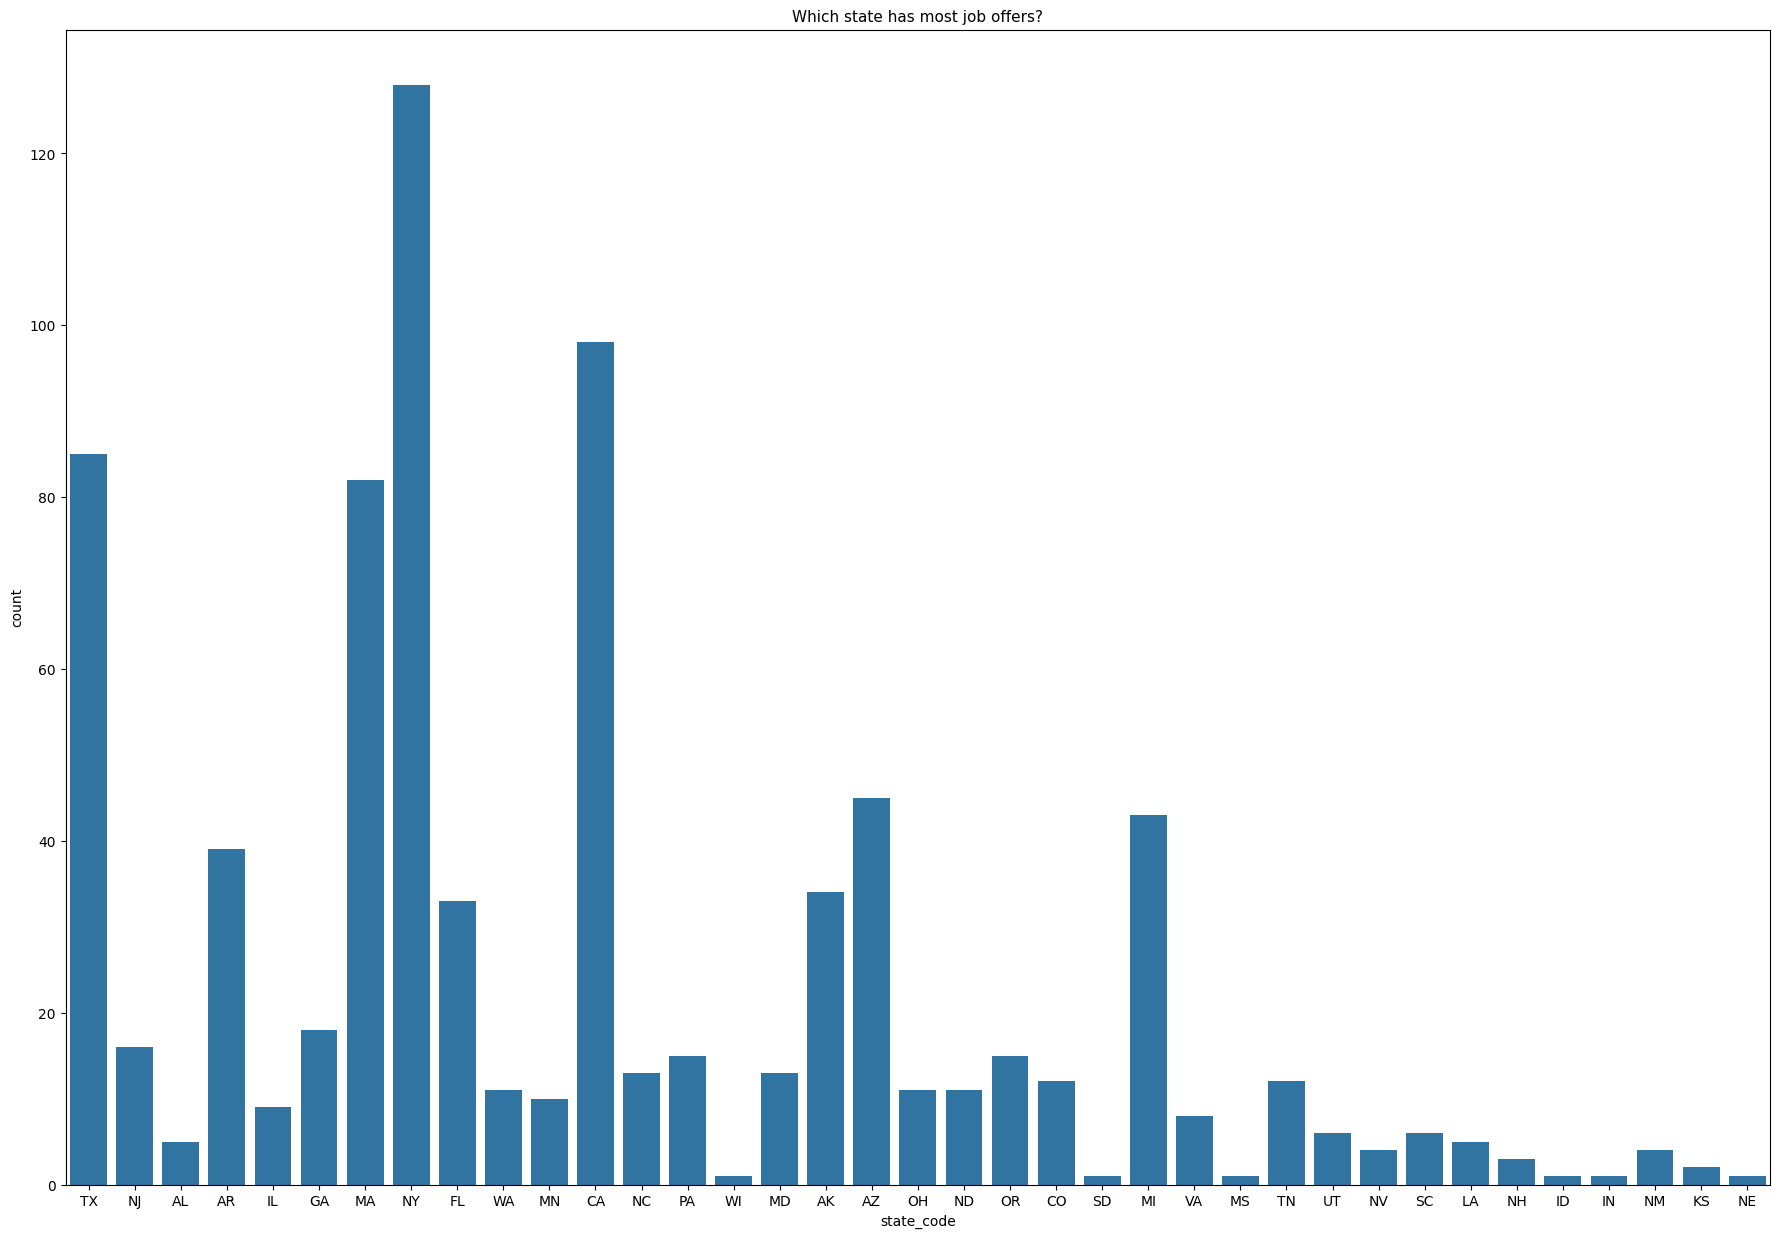

In [21]:
pyplot.figure(figsize=(20, 15))
pyplot.subplot(1, 2, 2)
sns.countplot(data = new_df, x = 'state_code')
pyplot.title('Which state has most job offers?', size=11)
pyplot.subplots_adjust(right=2)
pyplot.show()

Now you can clearly see the states with the most job offers are:

1. New York, NY.
2. California, CA.
3. Texas, TX.